In [6]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [7]:
mt_dis = xr.open_dataset('../output/mt+dis.nc')

In [8]:
mt_dis.AGregions

<xarray.DataArray 'AGregions' (band: 1, y: 1800, x: 3600)>
[6480000 values with dtype=int64]
Coordinates:
  * x            (x) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
  * y            (y) float64 89.97 89.87 89.77 89.67 ... -89.73 -89.83 -89.93
  * band         (band) int64 1
    spatial_ref  int64 ...

In [9]:
mt_dis.AGregions.sum()

<xarray.DataArray 'AGregions' ()>
array(713328)
Coordinates:
    spatial_ref  int64 ...

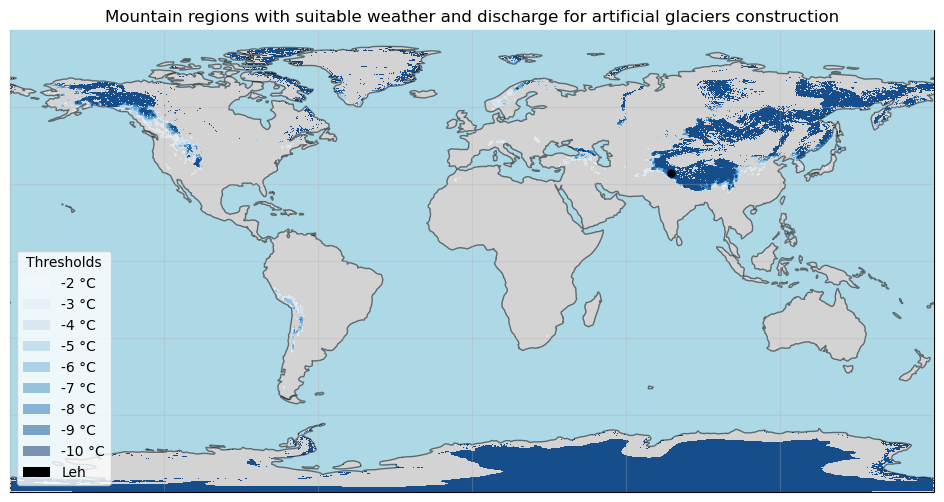

In [14]:
# Load the netCDF file
year = '2019'
dataset = xr.open_dataset('../data/wettasmin_W5E5v2.0_'+year+'.nc')
var = 'wet_temperature'

# Set the window size
window_size = 60

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset[var]

# Filter the dataset to the year 2001
year_dataset = dataset.sel(time=year)[var]

# Define the threshold range
thresholds = np.arange(-2, -11, -1)

# Create a figure and subplot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})



# Iterate over each threshold and plot filled contour regions
for i in range(len(thresholds)):
    threshold = thresholds[i]
    mask = year_dataset < threshold
    
    # Apply consecutive days condition
    consecutive_days = np.zeros_like(mask, dtype=int)
    consecutive_days[0] = mask[0].astype(int)
    
    for t in range(1, len(mask)):
        consecutive_days[t] = mask[t].astype(int) * (consecutive_days[t-1] + 1)
    
    mask_consecutive = consecutive_days >= window_size
    
    mask_2d = np.any(mask_consecutive, axis=0)
    
    ax.contourf(lon, lat, mask_2d, levels=[0.5, 1], colors=[plt.cm.Blues(i / (len(thresholds) - 1)), 'none'], alpha=0.5, hatches=[None, '////'], transform=ccrs.PlateCarree(), zorder=1)



# Create a custom colormap with lightgrey for 0 and None (transparent) for 1
cmap = plt.cm.colors.ListedColormap(['lightgrey', 'None'])
# Plot the 'Band1' data variable with the custom colormap
mt_dis.AGregions.plot(ax=ax, cmap=cmap, add_colorbar=False, zorder=3)

# Set the plot extent to cover the entire world
ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=4)

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')


# Set plot title and labels
ax.set_title('Mountain regions with suitable weather and discharge for artificial glaciers construction')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add map features
ax.coastlines(zorder=5, alpha=0.5)
ax.gridlines(zorder=5, alpha=0.3)

# Add a place marker for Leh
leh_coords = (34.163079280645604, 77.58554381044664)
ax.plot(leh_coords[1], leh_coords[0], marker='o', markersize=5, color='black', transform=ccrs.PlateCarree(), zorder=5)

# Create a custom legend
threshold_labels = [str(threshold) + ' °C' for threshold in thresholds]
legend_handles = [mpatches.Rectangle((0, 0), 1, 1, fc=plt.cm.Blues(i / (len(thresholds) - 1)), alpha=0.5) for i in range(len(thresholds))]
#no_discharge_handle = mpatches.Patch(color='red', label='No discharge')
leh_handle = mpatches.Circle((0, 0), 1, facecolor='black', alpha=1)

# Append the "No discharge" handle to the legend_handles list
legend_handles.append(leh_handle)

ax.legend(legend_handles, threshold_labels + ['Leh'], title='Thresholds', loc='lower left')


# Save the figure
#plt.savefig("../figs/mt_dis_wetbulb_layer.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()